In [ ]:
from unsloth import FastLanguageModel
import torch

max_seq_length = 32768 # Choose any! We auto support RoPE Scaling internally!
dtype = None # None for auto detection. Float16 for Tesla T4, V100, Bfloat16 for Ampere+
load_in_4bit = False # Use 4bit quantization to reduce memory usage. Can be False.

model, tokenizer = FastLanguageModel.from_pretrained(
    model_name = "ours_detector", # YOUR MODEL YOU USED FOR TRAINING
    max_seq_length = max_seq_length,
    dtype = dtype,
    load_in_4bit = load_in_4bit,
    full_finetuning = True
)
FastLanguageModel.for_inference(model) # Enable native 2x faster inference
FastLanguageModel.for_inference(model) # Enable native 2x faster inference

/usr/local/lib/python3.10/dist-packages/torch/utils/_pytree.py:185: FutureWarning: optree is installed but the version is too old to support PyTorch Dynamo in C++ pytree. C++ pytree support is disabled. Please consider upgrading optree using `python3 -m pip install --upgrade 'optree>=0.13.0'`.
  warnings.warn(


🦥 Unsloth: Will patch your computer to enable 2x faster free finetuning.


/usr/local/lib/python3.10/dist-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


🦥 Unsloth Zoo will now patch everything to make training faster!


/usr/local/lib/python3.10/dist-packages/torch/utils/_pytree.py:185: FutureWarning: optree is installed but the version is too old to support PyTorch Dynamo in C++ pytree. C++ pytree support is disabled. Please consider upgrading optree using `python3 -m pip install --upgrade 'optree>=0.13.0'`.
  warnings.warn(


INFO 06-12 08:55:57 [importing.py:53] Triton module has been replaced with a placeholder.
INFO 06-12 08:55:57 [__init__.py:239] Automatically detected platform cuda.


2025-06-12 08:55:59,942	INFO util.py:154 -- Missing packages: ['ipywidgets']. Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.


==((====))==  Unsloth 2025.5.3: Fast Qwen3 patching. Transformers: 4.51.3. vLLM: 0.8.5.
   \\   /|    Tesla V100-SXM2-32GB. Num GPUs = 1. Max memory: 31.749 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.6.0+cu124. CUDA: 7.0. CUDA Toolkit: 12.4. Triton: 3.2.0
\        /    Bfloat16 = FALSE. FA [Xformers = 0.0.29.post2. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!
Unsloth: Float16 full finetuning uses more memory since we upcast weights to float32.


Qwen3ForCausalLM(
  (model): Qwen3Model(
    (embed_tokens): Embedding(151936, 1024, padding_idx=151654)
    (layers): ModuleList(
      (0-27): 28 x Qwen3DecoderLayer(
        (self_attn): Qwen3Attention(
          (q_proj): Linear(in_features=1024, out_features=2048, bias=False)
          (k_proj): Linear(in_features=1024, out_features=1024, bias=False)
          (v_proj): Linear(in_features=1024, out_features=1024, bias=False)
          (o_proj): Linear(in_features=2048, out_features=1024, bias=False)
          (q_norm): Qwen3RMSNorm((128,), eps=1e-06)
          (k_norm): Qwen3RMSNorm((128,), eps=1e-06)
        )
        (mlp): Qwen3MLP(
          (gate_proj): Linear(in_features=1024, out_features=3072, bias=False)
          (up_proj): Linear(in_features=1024, out_features=3072, bias=False)
          (down_proj): Linear(in_features=3072, out_features=1024, bias=False)
          (act_fn): SiLU()
        )
        (input_layernorm): Qwen3RMSNorm((1024,), eps=1e-06)
        (post_atten

In [ ]:
from datasets import load_dataset

# Define the paths to your dataset files
data_files = {
    'train': 'smart_contract_train.csv',
    'val': 'smart_contract_val.csv',
    'test': 'smart_contract_test.csv'
}

# Load the dataset
dataset = load_dataset('csv', data_files=data_files)

import random

random.seed(42)

SYSTEM_PROMPT = [
    """You are the smartest AI solidity smart contract security auditor in the world.""",
    """You are the greatest AI assistant smart contract security auditor in the world.""",
    """You are the best solidity smart contract security auditor in the world""",
    """You are the greatest AI assistant solidity security researcher in the world""",
    """You are the best AI solidity smart contract security auditor in the world."""
]

PROMPTS = [
    """You need to analyze the given function and classify it as "Vulnerable Code" or "Safe Code" based on potential security risks.
    
    This is the function we need to audit:
    ```solidity
    {code}
    ```
    
Answer: """,
    
    """Analyze the given function and determine whether it is "Vulnerable Code" or "Safe Code" based on security risks.
    
    Function to audit:
    ```solidity
    {code}
    ```
    
Answer: """,

    """Examine the Solidity function below and assess if it is "Vulnerable Code" or "Safe Code."
    
    Solidity Function:
    ```solidity
    {code}
    ```
    
Answer: """,

    """Review the Solidity function and classify it as "Vulnerable Code" or "Safe Code" by checking for security issues.
    
    Solidity Function:
    ```solidity
    {code}
    ```
    
Answer: """,

    """Audit the given Solidity function to determine if it should be categorized as "Vulnerable Code" or "Safe Code."
    
    Solidity Code:
    ```solidity
    {code}
    ```
    
Answer: """,
]

def make_conversational_vote(examples, system_prompt, prompt):
    code = examples['code']
    vulnerable = "Vulnerable Code" if examples['vulnerable'] == 1 else "Safe Code"
    conversation = [
        {"role": "system", "content": system_prompt},
        {"role": "user", "content": prompt.format(code=code)}
    ]
    return {"conversations": conversation, "label": vulnerable}

# Generate 5 datasets using different prompts
datasets = []
for i in range(len(PROMPTS)):
    new_dataset = dataset.map(lambda ex: make_conversational_vote(ex, SYSTEM_PROMPT[i], PROMPTS[i]))
    new_dataset = new_dataset.remove_columns(["project_id", "code", "code_analysis", "vulnerable"])
    datasets.append(new_dataset)

In [3]:
from tqdm import tqdm
import re

# Inference with majority voting
pattern = r"<\|im_start\|>assistant\n<think>\n\n</think>\n\n(.*?)<\|im_end\|>"
y_preds = [[] for _ in range(5)]

for i, dataset in enumerate(datasets):
    for messages in tqdm(dataset['test']['conversations']):
        inputs = tokenizer.apply_chat_template(
            messages,
            tokenize=True,
            enable_thinking=False,
            add_generation_prompt=True,
            return_tensors="pt",
        ).to("cuda")
        
        #Temperature=0.7, TopP=0.8, TopK=20, and MinP=0.

        outputs = model.generate(
            input_ids=inputs,
            max_new_tokens=8,
            use_cache=True,
#             temperature=0.7,
#             top_p=0.8,
#             top_k=20,
#             min_p=0,
            temperature=0.1,
            min_p=0.1
        )
        decoded_output = tokenizer.batch_decode(outputs)[0]
        match = re.search(pattern, decoded_output, re.DOTALL)
        extracted_label = match.group(1).strip() if match else "Unknown"
        y_preds[i].append(extracted_label)
        
# Majority voting
final_predictions = []
for preds in zip(*y_preds):
    vote_count = {"Vulnerable Code": 0, "Safe Code": 0}
    for pred in preds:
        if pred in vote_count:
            vote_count[pred] += 1
    final_prediction = max(vote_count, key=vote_count.get)
    final_predictions.append(final_prediction)

print("Final Predictions:", final_predictions)

100%|██████████| 278/278 [01:03<00:00,  4.40it/s]

Final Predictions: ['Safe Code', 'Safe Code', 'Safe Code', 'Vulnerable Code', 'Safe Code', 'Safe Code', 'Vulnerable Code', 'Safe Code', 'Safe Code', 'Safe Code', 'Vulnerable Code', 'Safe Code', 'Safe Code', 'Safe Code', 'Safe Code', 'Safe Code', 'Vulnerable Code', 'Vulnerable Code', 'Vulnerable Code', 'Vulnerable Code', 'Safe Code', 'Safe Code', 'Safe Code', 'Vulnerable Code', 'Vulnerable Code', 'Vulnerable Code', 'Vulnerable Code', 'Vulnerable Code', 'Safe Code', 'Vulnerable Code', 'Safe Code', 'Safe Code', 'Safe Code', 'Safe Code', 'Safe Code', 'Safe Code', 'Vulnerable Code', 'Safe Code', 'Safe Code', 'Safe Code', 'Vulnerable Code', 'Safe Code', 'Safe Code', 'Vulnerable Code', 'Safe Code', 'Vulnerable Code', 'Vulnerable Code', 'Vulnerable Code', 'Vulnerable Code', 'Vulnerable Code', 'Safe Code', 'Safe Code', 'Safe Code', 'Safe Code', 'Safe Code', 'Vulnerable Code', 'Vulnerable Code', 'Safe Code', 'Vulnerable Code', 'Vulnerable Code', 'Safe Code', 'Safe Code', 'Safe Code', 'Safe Code'

              precision    recall  f1-score   support

           0       0.93      0.83      0.88       148
           1       0.83      0.93      0.88       130

    accuracy                           0.88       278
   macro avg       0.88      0.88      0.88       278
weighted avg       0.88      0.88      0.88       278



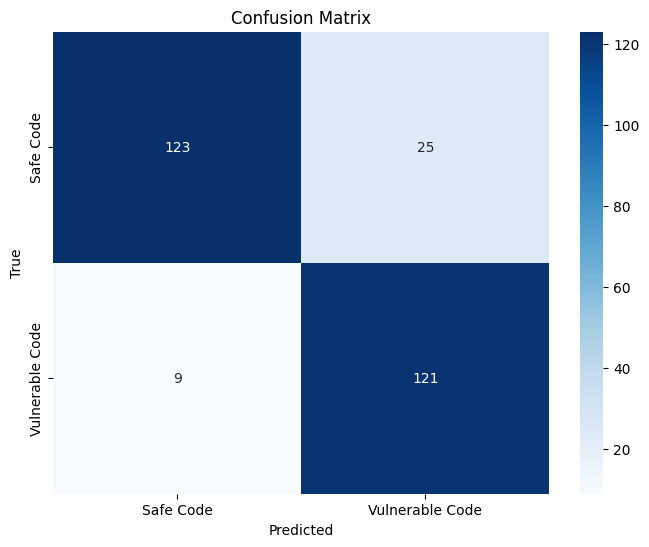

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.preprocessing import LabelEncoder

y_true = dataset['test']['label']

# Assuming y_true and y_pred_new are already defined
# Encode labels
label_encoder = LabelEncoder()
y_true_encoded = label_encoder.fit_transform(y_true)
y_pred_new_encoded = label_encoder.transform(final_predictions)

# Print classification report
print(classification_report(y_true_encoded, y_pred_new_encoded))

# Generate confusion matrix
cm = confusion_matrix(y_true_encoded, y_pred_new_encoded)

# Create a heatmap for the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [5]:
from sklearn.metrics import accuracy_score

# Accuracy of individual predictions
for i in range(5):
    accuracy = accuracy_score(y_true, y_preds[i])
    print(f"Accuracy of prompt {i+1} on test set: {accuracy:.4f}")

# Majority voting accuracy
majority_accuracy = accuracy_score(y_true, final_predictions)
print(f"Majority voting accuracy on test set: {majority_accuracy:.4f}")

# Inconsistent voting analysis
inconsistent_cases = [i for i, preds in enumerate(zip(*y_preds)) if len(set(preds)) > 1]
print(f"Number of inconsistent cases in test set: {len(inconsistent_cases)}")

Accuracy of prompt 1 on test set: 0.8705
Accuracy of prompt 2 on test set: 0.8705
Accuracy of prompt 3 on test set: 0.8813
Accuracy of prompt 4 on test set: 0.8741
Accuracy of prompt 5 on test set: 0.8741
Majority voting accuracy on test set: 0.8777
Number of inconsistent cases in test set: 10


In [7]:
cls_report = classification_report(y_true_encoded, y_pred_new_encoded, output_dict=True)

f1 = cls_report['macro avg']['f1-score']
recall = cls_report['macro avg']['recall']
precision = cls_report['macro avg']['precision']
accuracy = cls_report['accuracy']

response = f"""
SFT Training Done!
F1-Score: {f1}
Recall: {recall}
Precision: {precision}
Accuracy: {accuracy}
"""

print(response)


SFT Training Done!
F1-Score: 0.8776915113871635
Recall: 0.8809251559251559
Precision: 0.8802926525529264
Accuracy: 0.8776978417266187



In [8]:
import pickle

with open('y_preds_voting_new.pkl', 'wb') as file:
    pickle.dump(y_preds, file)
    
with open('y_test_voting_new.pkl', 'wb') as file:
    pickle.dump(y_true, file)

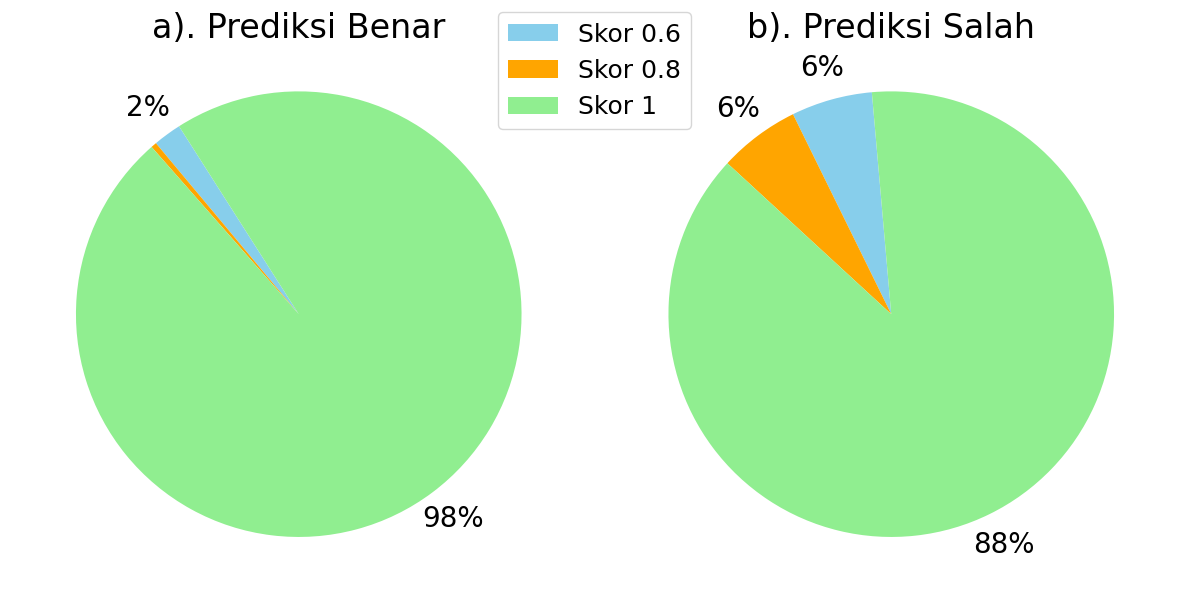

In [39]:
import pickle
import numpy as np
import matplotlib.pyplot as plt

# Step 1: Generate Dummy Data
np.random.seed(42)  # For reproducibility

# Load y_true and y_preds from a file
with open('y_test_voting_new.pkl', 'rb') as file:
    y_true = pickle.load(file)

with open('y_preds_voting_new.pkl', 'rb') as file:
    y_preds = pickle.load(file)

# Step 2: Majority Voting
final_predictions = []
confidence_scores = []

for preds in zip(*y_preds):
    vote_count = {"Vulnerable Code": 0, "Safe Code": 0}
    for pred in preds:
        vote_count[pred] += 1
    majority_class = max(vote_count, key=vote_count.get)
    final_predictions.append(majority_class)
    majority_votes = max(vote_count.values())
    confidence_score = majority_votes / len(preds)
    confidence_scores.append(confidence_score)

# Step 3: Classify Correct and Wrong Predictions
correct_confidences = []
wrong_confidences = []

for true_label, pred_label, conf_score in zip(y_true, final_predictions, confidence_scores):
    if true_label == pred_label:
        correct_confidences.append(conf_score)
    else:
        wrong_confidences.append(conf_score)

# Step 4: Group Confidence Scores into Bins
def count_confidence_scores(scores):
    counts = np.unique(scores, return_counts=True)[1]
    return counts

# Group correct and wrong predictions
correct_counts = count_confidence_scores(correct_confidences)
wrong_counts = count_confidence_scores(wrong_confidences)

# Normalize counts to percentages
correct_percentages = (correct_counts / sum(correct_counts)) * 100
wrong_percentages = (wrong_counts / sum(wrong_counts)) * 100

# Labels for the pie charts
# labels = ["Score 0.6", "Score 0.8", "Score 1"]
labels = ["Skor 0.6", "Skor 0.8", "Skor 1"]

# Step 5: Plot the Pie Charts
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Correct Prediction Pie Chart
axes[0].pie(
    correct_percentages,
    # labels=labels,
    autopct=lambda p: '{:.0f}%'.format(p) if p > 1 else '',
    pctdistance=1.15, 
    # labeldistance=.6,
    startangle=122.5,
    colors=['skyblue', 'orange', 'lightgreen'],
    # wedgeprops=dict(width=0.4),
    textprops={'fontsize': 20},
)
# axes[0].set_title("a). Correct Prediction", fontsize=24)
axes[0].set_title("a). Prediksi Benar", fontsize=24)
axes[0].axis('equal')  # Equal aspect ratio ensures the pie is circular

# Wrong Prediction Pie Chart
axes[1].pie(
    wrong_percentages,
    # labels=labels,
    autopct=lambda p: '{:.0f}%'.format(p) if p > 1 else '',
    pctdistance=1.15, 
    # labeldistance=.6,
    startangle=95,
    colors=['skyblue', 'orange', 'lightgreen'],
    # wedgeprops=dict(width=0.4),
    textprops={'fontsize': 20},
)
# axes[1].set_title("b). Wrong Prediction", fontsize=24)
axes[1].set_title("b). Prediksi Salah", fontsize=24)
axes[1].axis('equal')  # Equal aspect ratio ensures the pie is circular

# Add a legend
fig.legend(labels, prop = { "size": 18 }, loc="upper center")

# Add a main title
# plt.suptitle("The Distribution of Voting Scores for Correct Predictions and Wrong Predictions", fontsize=16)

# Adjust layout
plt.tight_layout()  # Make space for the legend

# Show the plot
# plt.show()
plt.savefig('_plot_result/detection_pie_voting.pdf', format='pdf', dpi=1000)

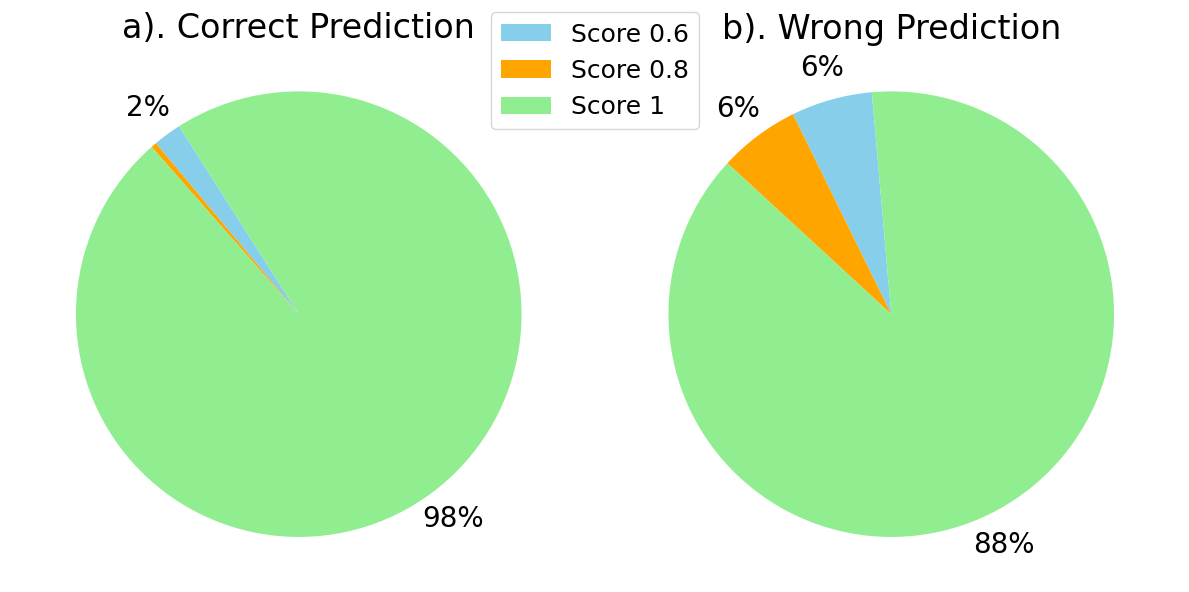

In [32]:
import pickle
import numpy as np
import matplotlib.pyplot as plt

# Step 1: Generate Dummy Data
np.random.seed(42)  # For reproducibility

# Load y_true and y_preds from a file
with open('y_test_voting_new.pkl', 'rb') as file:
    y_true = pickle.load(file)

with open('y_preds_voting_new.pkl', 'rb') as file:
    y_preds = pickle.load(file)

# Step 2: Majority Voting
final_predictions = []
confidence_scores = []

for preds in zip(*y_preds):
    vote_count = {"Vulnerable Code": 0, "Safe Code": 0}
    for pred in preds:
        vote_count[pred] += 1
    majority_class = max(vote_count, key=vote_count.get)
    final_predictions.append(majority_class)
    majority_votes = max(vote_count.values())
    confidence_score = majority_votes / len(preds)
    confidence_scores.append(confidence_score)

# Step 3: Classify Correct and Wrong Predictions
correct_confidences = []
wrong_confidences = []

for true_label, pred_label, conf_score in zip(y_true, final_predictions, confidence_scores):
    if true_label == pred_label:
        correct_confidences.append(conf_score)
    else:
        wrong_confidences.append(conf_score)

# Step 4: Group Confidence Scores into Bins
def count_confidence_scores(scores):
    counts = np.unique(scores, return_counts=True)[1]
    return counts

# Group correct and wrong predictions
correct_counts = count_confidence_scores(correct_confidences)
wrong_counts = count_confidence_scores(wrong_confidences)

# Normalize counts to percentages
correct_percentages = (correct_counts / sum(correct_counts)) * 100
wrong_percentages = (wrong_counts / sum(wrong_counts)) * 100

# Labels for the pie charts
labels = ["Score 0.6", "Score 0.8", "Score 1"]
# labels = ["Skor 0.6", "Skor 0.8", "Skor 1"]

# Step 5: Plot the Pie Charts
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Correct Prediction Pie Chart
axes[0].pie(
    correct_percentages,
    # labels=labels,
    autopct=lambda p: '{:.0f}%'.format(p) if p > 1 else '',
    pctdistance=1.15, 
    # labeldistance=.6,
    startangle=122.5,
    colors=['skyblue', 'orange', 'lightgreen'],
    # wedgeprops=dict(width=0.4),
    textprops={'fontsize': 20},
)
axes[0].set_title("a). Correct Prediction", fontsize=24)
# axes[0].set_title("a). Prediksi Benar", fontsize=24)
axes[0].axis('equal')  # Equal aspect ratio ensures the pie is circular

# Wrong Prediction Pie Chart
axes[1].pie(
    wrong_percentages,
    # labels=labels,
    autopct=lambda p: '{:.0f}%'.format(p) if p > 1 else '',
    pctdistance=1.15, 
    # labeldistance=.6,
    startangle=95,
    colors=['skyblue', 'orange', 'lightgreen'],
    # wedgeprops=dict(width=0.4),
    textprops={'fontsize': 20},
)
axes[1].set_title("b). Wrong Prediction", fontsize=24)
# axes[1].set_title("b). Prediksi Salah", fontsize=24)
axes[1].axis('equal')  # Equal aspect ratio ensures the pie is circular

# Add a legend
fig.legend(labels, prop = { "size": 18 }, loc="upper center")

# Add a main title
# plt.suptitle("The Distribution of Voting Scores for Correct Predictions and Wrong Predictions", fontsize=16)

# Adjust layout
plt.tight_layout()  # Make space for the legend

# Show the plot
# plt.show()
plt.savefig('_plot_result/detection_pie_voting_eng.pdf', format='pdf', dpi=1000)

              precision    recall  f1-score   support

           0       0.93      0.83      0.88       148
           1       0.83      0.93      0.88       130

    accuracy                           0.88       278
   macro avg       0.88      0.88      0.88       278
weighted avg       0.88      0.88      0.88       278



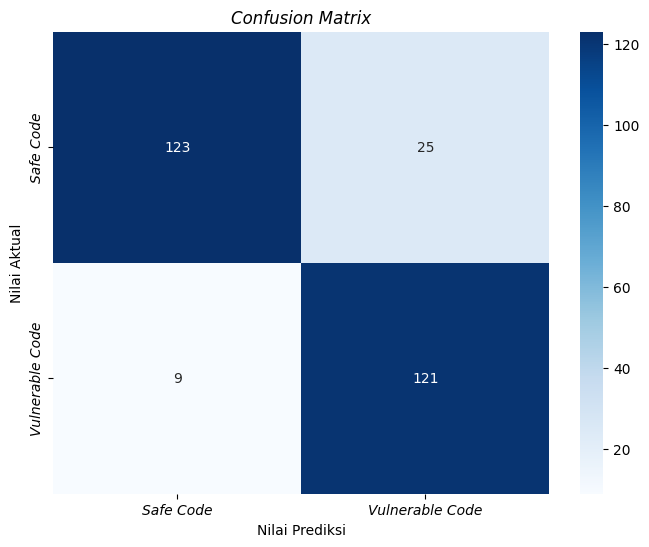

In [33]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.preprocessing import LabelEncoder

# Assuming y_true and y_pred_new are already defined
# Encode labels
label_encoder = LabelEncoder()
y_true_encoded = label_encoder.fit_transform(y_true)
y_pred_new_encoded = label_encoder.transform(final_predictions)

# Print classification report
print(classification_report(y_true_encoded, y_pred_new_encoded))

# Generate confusion matrix
cm = confusion_matrix(y_true_encoded, y_pred_new_encoded)

# Create a heatmap for the confusion matrix
plt.figure(figsize=(8, 6))
# sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
ax = sns.heatmap(
    cm, annot=True, fmt="d", cmap="Blues",
    xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_
)

# Italicize all xticks and yticks
for label in ax.get_xticklabels() + ax.get_yticklabels():
    label.set_fontstyle("italic")

# plt.xlabel('Predicted')
plt.xlabel('Nilai Prediksi')
# plt.ylabel('True')
plt.ylabel('Nilai Aktual')
plt.title('Confusion Matrix', fontstyle='italic')
# plt.show()
plt.savefig('_plot_result/detection_conf_matrix.pdf', format='pdf', dpi=1000)

              precision    recall  f1-score   support

           0     0.9318    0.8311    0.8786       148
           1     0.8288    0.9308    0.8768       130

    accuracy                         0.8777       278
   macro avg     0.8803    0.8809    0.8777       278
weighted avg     0.8836    0.8777    0.8777       278



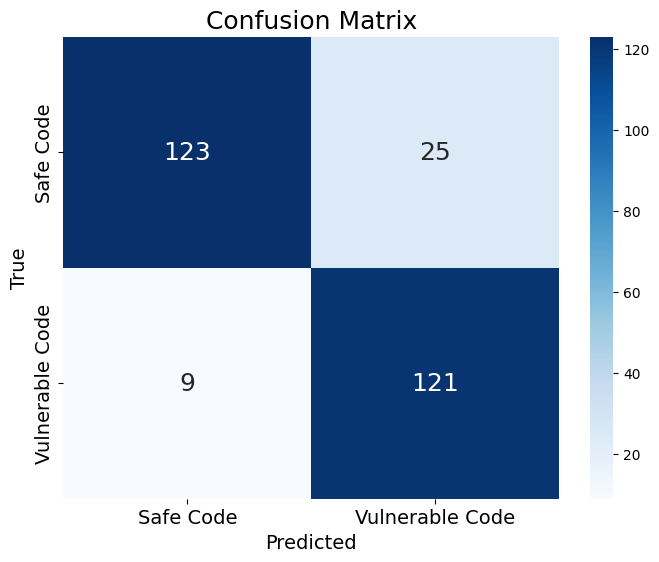

In [34]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.preprocessing import LabelEncoder

# Assuming y_true and y_pred_new are already defined
# Encode labels
label_encoder = LabelEncoder()
y_true_encoded = label_encoder.fit_transform(y_true)
y_pred_new_encoded = label_encoder.transform(final_predictions)

# Print classification report
print(classification_report(y_true_encoded, y_pred_new_encoded, digits=4))

# Generate confusion matrix
cm = confusion_matrix(y_true_encoded, y_pred_new_encoded)

# Create a heatmap for the confusion matrix
plt.figure(figsize=(8, 6))
# sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
ax = sns.heatmap(
    cm, annot=True, fmt="d", cmap="Blues",
    xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_,
    annot_kws={"size": 18}
)

# # Italicize all xticks and yticks
# for label in ax.get_xticklabels() + ax.get_yticklabels():
#     label.set_fontstyle("italic")

# Italicize all xticks and yticks
for label in ax.get_xticklabels() + ax.get_yticklabels():
    label.set_fontsize(14)

plt.xlabel('Predicted', fontsize=14)
# plt.xlabel('Nilai Prediksi')
plt.ylabel('True', fontsize=14)
# plt.ylabel('Nilai Aktual')
# plt.title('Confusion Matrix', fontstyle='italic')
plt.title('Confusion Matrix', fontsize=18)
# plt.show()
plt.savefig('_plot_result/detection_conf_matrix_eng.pdf', format='pdf', dpi=1000)

In [59]:
from sklearn.metrics import classification_report
import numpy as np

def classification_report_from_confusion_matrix(cm, target_names=None):
    """
    Generate a classification report from a 2x2 confusion matrix.

    Args:
        cm (list or np.ndarray): 2x2 confusion matrix [[TN, FP], [FN, TP]]
        target_names (list): Optional list of class names, e.g., ['Not Vulnerable', 'Vulnerable']

    Returns:
        str: Classification report as a string
    """
    cm = np.array(cm)
    if cm.shape != (2, 2):
        raise ValueError("Confusion matrix must be 2x2.")
    
    # Expand confusion matrix into y_true and y_pred arrays
    tn, fp, fn, tp = cm[0,0], cm[0,1], cm[1,0], cm[1,1]

    y_true = (
        [0]*(tn + fp) +  # true negatives + false positives
        [1]*(fn + tp)    # false negatives + true positives
    )
    y_pred = (
        [0]*tn + [1]*fp +  # predictions for true negatives + false positives
        [0]*fn + [1]*tp    # predictions for false negatives + true positives
    )

    # Default target names if not provided
    if target_names is None:
        target_names = ['Class 0', 'Class 1']

    # Generate and return classification report
    return classification_report(y_true, y_pred, target_names=target_names, digits=4)

In [17]:
# CodeBERT

cm = [[128, 20], [19, 111]]
report = classification_report_from_confusion_matrix(cm, target_names=['Not Vulnerable', 'Vulnerable'])
print(report)

                precision    recall  f1-score   support

Not Vulnerable     0.8707    0.8649    0.8678       148
    Vulnerable     0.8473    0.8538    0.8506       130

      accuracy                         0.8597       278
     macro avg     0.8590    0.8594    0.8592       278
  weighted avg     0.8598    0.8597    0.8597       278



In [18]:
# GraphCodeBERT

cm = [[123, 25], [21, 109]]
report = classification_report_from_confusion_matrix(cm, target_names=['Not Vulnerable', 'Vulnerable'])
print(report)

                precision    recall  f1-score   support

Not Vulnerable     0.8542    0.8311    0.8425       148
    Vulnerable     0.8134    0.8385    0.8258       130

      accuracy                         0.8345       278
     macro avg     0.8338    0.8348    0.8341       278
  weighted avg     0.8351    0.8345    0.8347       278



In [19]:
# CodeT5

cm = [[119, 29], [20, 110]]
report = classification_report_from_confusion_matrix(cm, target_names=['Not Vulnerable', 'Vulnerable'])
print(report)

                precision    recall  f1-score   support

Not Vulnerable     0.8561    0.8041    0.8293       148
    Vulnerable     0.7914    0.8462    0.8178       130

      accuracy                         0.8237       278
     macro avg     0.8237    0.8251    0.8236       278
  weighted avg     0.8258    0.8237    0.8239       278



In [21]:
# UnixCoder

cm = [[135, 13], [27, 103]]
report = classification_report_from_confusion_matrix(cm, target_names=['Not Vulnerable', 'Vulnerable'])
print(report)

                precision    recall  f1-score   support

Not Vulnerable     0.8333    0.9122    0.8710       148
    Vulnerable     0.8879    0.7923    0.8374       130

      accuracy                         0.8561       278
     macro avg     0.8606    0.8522    0.8542       278
  weighted avg     0.8589    0.8561    0.8553       278



In [60]:
# CodeLlama

cm = [[128, 20], [17, 113]]
report = classification_report_from_confusion_matrix(cm, target_names=['Not Vulnerable', 'Vulnerable'])
print(report)

                precision    recall  f1-score   support

Not Vulnerable     0.8828    0.8649    0.8737       148
    Vulnerable     0.8496    0.8692    0.8593       130

      accuracy                         0.8669       278
     macro avg     0.8662    0.8670    0.8665       278
  weighted avg     0.8673    0.8669    0.8670       278



In [ ]:
import pandas as pd

df_train = pd.read_csv("smart_contract_train.csv")
df_val = pd.read_csv("smart_contract_val.csv")
df_test = pd.read_csv("smart_contract_test.csv")

df_merged = pd.concat([df_train,df_val,df_test])
df_merged['vulnerable'].value_counts()

0    1031
1     852
Name: vulnerable, dtype: int64

In [ ]:
import pandas as pd

df_train = pd.read_csv("severity_data_train.csv")
df_val = pd.read_csv("severity_data_val.csv")
df_test = pd.read_csv("severity_data_test.csv")

df_merged = pd.concat([df_train,df_val,df_test])
df_merged['severity'].value_counts()

medium    490
high      299
low       158
Name: severity, dtype: int64

In [ ]:
from unsloth import FastLanguageModel
import torch

max_seq_length = 32768 # Choose any! We auto support RoPE Scaling internally!
dtype = None # None for auto detection. Float16 for Tesla T4, V100, Bfloat16 for Ampere+
load_in_4bit = False # Use 4bit quantization to reduce memory usage. Can be False.

model, tokenizer = FastLanguageModel.from_pretrained(
    model_name = "ours_severity", # YOUR MODEL YOU USED FOR TRAINING
    max_seq_length = max_seq_length,
    dtype = dtype,
    load_in_4bit = load_in_4bit,
    full_finetuning = True
)
FastLanguageModel.for_inference(model) # Enable native 2x faster inference
# FastLanguageModel.for_inference(model) # Enable native 2x faster inference

/usr/local/lib/python3.10/dist-packages/torch/utils/_pytree.py:185: FutureWarning: optree is installed but the version is too old to support PyTorch Dynamo in C++ pytree. C++ pytree support is disabled. Please consider upgrading optree using `python3 -m pip install --upgrade 'optree>=0.13.0'`.
  warnings.warn(


🦥 Unsloth: Will patch your computer to enable 2x faster free finetuning.


/usr/local/lib/python3.10/dist-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


🦥 Unsloth Zoo will now patch everything to make training faster!


/usr/local/lib/python3.10/dist-packages/torch/utils/_pytree.py:185: FutureWarning: optree is installed but the version is too old to support PyTorch Dynamo in C++ pytree. C++ pytree support is disabled. Please consider upgrading optree using `python3 -m pip install --upgrade 'optree>=0.13.0'`.
  warnings.warn(


INFO 06-12 10:19:55 [importing.py:53] Triton module has been replaced with a placeholder.
INFO 06-12 10:19:55 [__init__.py:239] Automatically detected platform cuda.


2025-06-12 10:19:57,889	INFO util.py:154 -- Missing packages: ['ipywidgets']. Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.


==((====))==  Unsloth 2025.5.3: Fast Qwen3 patching. Transformers: 4.51.3. vLLM: 0.8.5.
   \\   /|    Tesla V100-SXM2-32GB. Num GPUs = 1. Max memory: 31.749 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.6.0+cu124. CUDA: 7.0. CUDA Toolkit: 12.4. Triton: 3.2.0
\        /    Bfloat16 = FALSE. FA [Xformers = 0.0.29.post2. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!
Unsloth: Float16 full finetuning uses more memory since we upcast weights to float32.


Qwen3ForCausalLM(
  (model): Qwen3Model(
    (embed_tokens): Embedding(151936, 1024, padding_idx=151654)
    (layers): ModuleList(
      (0-27): 28 x Qwen3DecoderLayer(
        (self_attn): Qwen3Attention(
          (q_proj): Linear(in_features=1024, out_features=2048, bias=False)
          (k_proj): Linear(in_features=1024, out_features=1024, bias=False)
          (v_proj): Linear(in_features=1024, out_features=1024, bias=False)
          (o_proj): Linear(in_features=2048, out_features=1024, bias=False)
          (q_norm): Qwen3RMSNorm((128,), eps=1e-06)
          (k_norm): Qwen3RMSNorm((128,), eps=1e-06)
        )
        (mlp): Qwen3MLP(
          (gate_proj): Linear(in_features=1024, out_features=3072, bias=False)
          (up_proj): Linear(in_features=1024, out_features=3072, bias=False)
          (down_proj): Linear(in_features=3072, out_features=1024, bias=False)
          (act_fn): SiLU()
        )
        (input_layernorm): Qwen3RMSNorm((1024,), eps=1e-06)
        (post_atten

In [ ]:
from datasets import load_dataset

# Define the paths to your dataset files
data_files = {
    'train': 'severity_data_train.csv',
    'val': 'severity_data_val.csv',
    'test': 'severity_data_test.csv'
}

# Load the dataset
dataset = load_dataset('csv', data_files=data_files)

import random
from datasets import concatenate_datasets, DatasetDict

random.seed(42)

SYSTEM_PROMPT = [
    """You are the smartest AI solidity smart contract security auditor in the world.""",
    """You are the greatest AI assistant smart contract security auditor in the world.""",
    """You are the best solidity smart contract security auditor in the world""",
    """You are the greatest AI assistant solidity security researcher in the world""",
    """You are the best AI solidity smart contract security auditor in the world."""
]

PROMPTS = [
    """You need to analyze the given vulnerability explanation and classify the severity of it as "low", "medium" or "high" based on the impact of that vulnerability.
    
    This is the vulnerability explanation we need to analyze:
    {explanation}
    
Answer: """,
    
    """Analyze the given vulnerability explanation and determine whether the severity is "low", "medium" or "high" based on the impact if the vulnerability exploited.
    
    Vulnerability explanation to analyze:
    {explanation}
    
Answer: """,

    """Examine the given vulnerability explanation below and assess the severity is it "low", "medium" or "high".
    
    Vulnerability explanation to examine:
    {explanation}
    
Answer: """,

    """Review the vulnerability explanation and classify the severity as "low", "medium" or "high" by checking if the exploitation is occured then how is it will impact the system.
    
    Vulnerability explanation:
    {explanation}
    
Answer: """,

    """Audit the given vulnerability explanation to determine if the severity should be categorized as "low", "medium" or "high".
    
    Vulnerability explanation:
    {explanation}
    
Answer: """,
]

def make_conversational_vote(examples, system_prompt, prompt):
    explanation = examples['vuln_explanation']
    severity = examples['severity']
    selected_system_prompt = system_prompt
    selected_user_prompt = prompt
    conversation = [{"role": "system", "content": selected_system_prompt}, 
                    {"role": "user", "content": selected_user_prompt.format(explanation=explanation)}]
    
    return { "conversations" : conversation, 'label': severity}

# Generate 5 datasets using different prompts
datasets = []
for i in range(len(PROMPTS)):
    new_dataset = dataset.map(lambda ex: make_conversational_vote(ex, SYSTEM_PROMPT[i], PROMPTS[i]))
    new_dataset = new_dataset.remove_columns(["file_name", "vuln_title", "vuln_explanation", "vuln_recommendation", "vuln_code"])
    datasets.append(new_dataset)
    
test_dataset = datasets[0]['test']

Generating train split: 662 examples [00:00, 17424.83 examples/s]
Generating val split: 142 examples [00:00, 13728.04 examples/s]
Generating test split: 143 examples [00:00, 14566.03 examples/s]
Map: 100%|██████████| 143/143 [00:00<00:00, 4913.01 examples/s]


In [75]:
from tqdm import tqdm
import re

# Inference with majority voting
pattern = r"<\|im_start\|>assistant\n<think>\n\n</think>\n\n(.*?)<\|im_end\|>"
y_preds = [[] for _ in range(5)]

for i, dataset in enumerate(datasets):
    for messages in tqdm(dataset['test']['conversations']):
        inputs = tokenizer.apply_chat_template(
            messages,
            tokenize=True,
            enable_thinking=False,
            add_generation_prompt=True,
            return_tensors="pt",
        ).to("cuda")

        outputs = model.generate(
            input_ids=inputs,
            max_new_tokens=8,
            use_cache=True,
#             temperature=0.7,
#             top_p=0.8,
#             top_k=20,
#             min_p=0,
            temperature=0.1,
            min_p=0.1
        )
        decoded_output = tokenizer.batch_decode(outputs)[0]
        match = re.search(pattern, decoded_output, re.DOTALL)
        extracted_label = match.group(1).strip() if match else "Unknown"
        y_preds[i].append(extracted_label)
        
# Majority voting
final_predictions = []
for preds in zip(*y_preds):
    vote_count = {"low": 0, "medium": 0, "high": 0}
    for pred in preds:
        if pred in vote_count:
            vote_count[pred] += 1
    final_prediction = max(vote_count, key=vote_count.get)
    final_predictions.append(final_prediction)

print("Final Predictions:", final_predictions)

100%|██████████| 143/143 [00:19<00:00,  7.19it/s]

Final Predictions: ['medium', 'medium', 'high', 'medium', 'medium', 'medium', 'medium', 'high', 'low', 'high', 'low', 'medium', 'medium', 'low', 'medium', 'medium', 'medium', 'high', 'medium', 'high', 'high', 'high', 'low', 'medium', 'low', 'low', 'high', 'medium', 'medium', 'high', 'high', 'medium', 'low', 'medium', 'high', 'low', 'medium', 'high', 'medium', 'medium', 'medium', 'low', 'medium', 'low', 'medium', 'medium', 'high', 'high', 'low', 'high', 'medium', 'medium', 'high', 'medium', 'high', 'medium', 'medium', 'medium', 'high', 'high', 'high', 'medium', 'high', 'medium', 'medium', 'high', 'high', 'medium', 'medium', 'medium', 'medium', 'high', 'medium', 'medium', 'high', 'medium', 'low', 'medium', 'high', 'medium', 'medium', 'high', 'medium', 'medium', 'low', 'high', 'medium', 'medium', 'low', 'medium', 'high', 'low', 'medium', 'medium', 'medium', 'medium', 'medium', 'medium', 'low', 'high', 'medium', 'low', 'medium', 'medium', 'medium', 'high', 'high', 'high', 'medium', 'low', 

              precision    recall  f1-score   support

         low       0.62      0.54      0.58        24
      medium       0.68      0.74      0.71        74
        high       0.66      0.60      0.63        45

    accuracy                           0.66       143
   macro avg       0.65      0.63      0.64       143
weighted avg       0.66      0.66      0.66       143



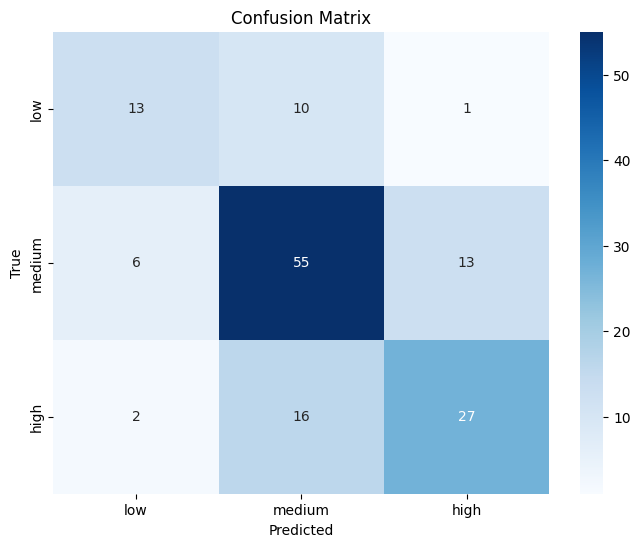

In [76]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

y_true = dataset['test']['label']

# Define your desired order
label_order = ['low', 'medium', 'high']
label_to_int = {label: i for i, label in enumerate(label_order)}

# Map labels to integers using the custom order
y_true_encoded = [label_to_int[label] for label in y_true]
y_pred_new_encoded = [label_to_int[label] for label in final_predictions]

# Print classification report
print(classification_report(y_true_encoded, y_pred_new_encoded, target_names=label_order))

# Generate confusion matrix
cm = confusion_matrix(y_true_encoded, y_pred_new_encoded)

# Create a heatmap for the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=label_order, yticklabels=label_order)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [80]:
cls_report = classification_report(y_true_encoded, y_pred_new_encoded, output_dict=True)

f1 = cls_report['macro avg']['f1-score']
recall = cls_report['macro avg']['recall']
precision = cls_report['macro avg']['precision']
accuracy = cls_report['accuracy']

response = f"""
SFT Training Done!
F1-Score: {f1}
Recall: {recall}
Precision: {precision}
Accuracy: {accuracy}
"""

print(response)


SFT Training Done!
F1-Score: 0.6384540579589342
Recall: 0.6283033033033033
Precision: 0.6521988500308283
Accuracy: 0.6643356643356644



In [82]:
import pickle

with open('y_preds_voting_severity.pkl', 'wb') as file:
    pickle.dump(y_preds, file)
    
with open('y_test_voting_severity.pkl', 'wb') as file:
    pickle.dump(y_true, file)

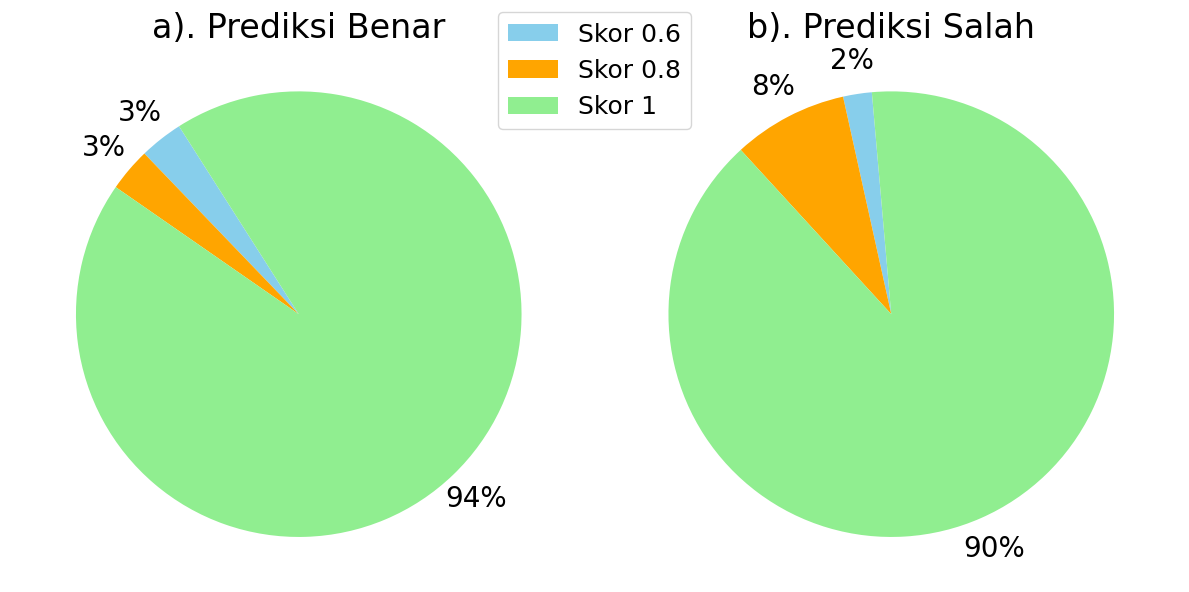

In [2]:
import pickle
import numpy as np
import matplotlib.pyplot as plt

# Step 1: Generate Dummy Data
np.random.seed(42)  # For reproducibility

# Load y_true and y_preds from a file
with open('y_test_voting_severity.pkl', 'rb') as file:
    y_true = pickle.load(file)

with open('y_preds_voting_severity.pkl', 'rb') as file:
    y_preds = pickle.load(file)

# Step 2: Majority Voting
final_predictions = []
confidence_scores = []

for preds in zip(*y_preds):
    vote_count = {"low": 0, "medium": 0, "high": 0}
    for pred in preds:
        if pred in vote_count:
            vote_count[pred] += 1
    majority_class = max(vote_count, key=vote_count.get)
    final_predictions.append(majority_class)
    majority_votes = max(vote_count.values())
    confidence_score = majority_votes / len(preds)
    confidence_scores.append(confidence_score)

# Step 3: Classify Correct and Wrong Predictions
correct_confidences = []
wrong_confidences = []

for true_label, pred_label, conf_score in zip(y_true, final_predictions, confidence_scores):
    if true_label == pred_label:
        correct_confidences.append(conf_score)
    else:
        wrong_confidences.append(conf_score)

# Step 4: Group Confidence Scores into Bins
def count_confidence_scores(scores):
    counts = np.unique(scores, return_counts=True)[1]
    return counts

# Group correct and wrong predictions
correct_counts = count_confidence_scores(correct_confidences)
wrong_counts = count_confidence_scores(wrong_confidences)

# Normalize counts to percentages
correct_percentages = (correct_counts / sum(correct_counts)) * 100
wrong_percentages = (wrong_counts / sum(wrong_counts)) * 100

# Labels for the pie charts
# labels = ["Score 0.6", "Score 0.8", "Score 1"]
labels = ["Skor 0.6", "Skor 0.8", "Skor 1"]

# Step 5: Plot the Pie Charts
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Correct Prediction Pie Chart
axes[0].pie(
    correct_percentages,
    # labels=labels,
    autopct=lambda p: '{:.0f}%'.format(p) if p > 1 else '',
    pctdistance=1.15, 
    # labeldistance=.6,
    startangle=122.5,
    colors=['skyblue', 'orange', 'lightgreen'],
    # wedgeprops=dict(width=0.4),
    textprops={'fontsize': 20},
)
# axes[0].set_title("a). Correct Prediction", fontsize=24)
axes[0].set_title("a). Prediksi Benar", fontsize=24)
axes[0].axis('equal')  # Equal aspect ratio ensures the pie is circular

# Wrong Prediction Pie Chart
axes[1].pie(
    wrong_percentages,
    # labels=labels,
    autopct=lambda p: '{:.0f}%'.format(p) if p > 1 else '',
    pctdistance=1.15, 
    # labeldistance=.6,
    startangle=95,
    colors=['skyblue', 'orange', 'lightgreen'],
    # wedgeprops=dict(width=0.4),
    textprops={'fontsize': 20},
)
# axes[1].set_title("b). Wrong Prediction", fontsize=24)
axes[1].set_title("b). Prediksi Salah", fontsize=24)
axes[1].axis('equal')  # Equal aspect ratio ensures the pie is circular

# Add a legend
fig.legend(labels, prop = { "size": 18 }, loc="upper center")

# Add a main title
# plt.suptitle("The Distribution of Voting Scores for Correct Predictions and Wrong Predictions", fontsize=16)

# Adjust layout
plt.tight_layout()  # Make space for the legend

# Show the plot
# plt.show()
plt.savefig('_plot_result/severity_pie_voting.pdf', format='pdf', dpi=1000)

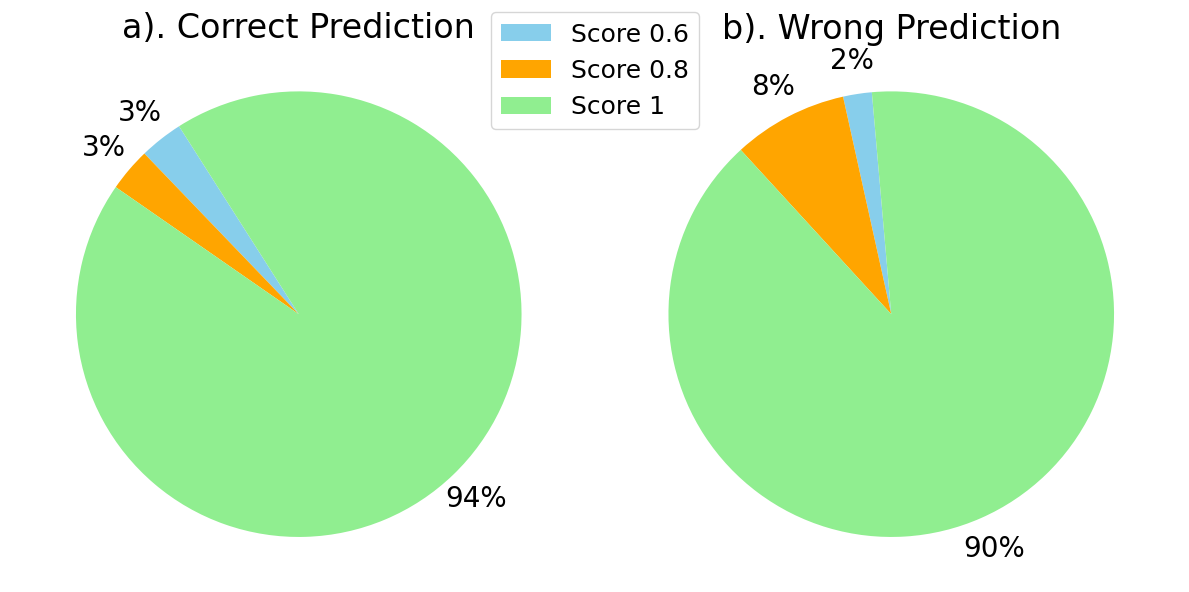

In [35]:
import pickle
import numpy as np
import matplotlib.pyplot as plt

# Step 1: Generate Dummy Data
np.random.seed(42)  # For reproducibility

# Load y_true and y_preds from a file
with open('y_test_voting_severity.pkl', 'rb') as file:
    y_true = pickle.load(file)

with open('y_preds_voting_severity.pkl', 'rb') as file:
    y_preds = pickle.load(file)

# Step 2: Majority Voting
final_predictions = []
confidence_scores = []

for preds in zip(*y_preds):
    vote_count = {"low": 0, "medium": 0, "high": 0}
    for pred in preds:
        if pred in vote_count:
            vote_count[pred] += 1
    majority_class = max(vote_count, key=vote_count.get)
    final_predictions.append(majority_class)
    majority_votes = max(vote_count.values())
    confidence_score = majority_votes / len(preds)
    confidence_scores.append(confidence_score)

# Step 3: Classify Correct and Wrong Predictions
correct_confidences = []
wrong_confidences = []

for true_label, pred_label, conf_score in zip(y_true, final_predictions, confidence_scores):
    if true_label == pred_label:
        correct_confidences.append(conf_score)
    else:
        wrong_confidences.append(conf_score)

# Step 4: Group Confidence Scores into Bins
def count_confidence_scores(scores):
    counts = np.unique(scores, return_counts=True)[1]
    return counts

# Group correct and wrong predictions
correct_counts = count_confidence_scores(correct_confidences)
wrong_counts = count_confidence_scores(wrong_confidences)

# Normalize counts to percentages
correct_percentages = (correct_counts / sum(correct_counts)) * 100
wrong_percentages = (wrong_counts / sum(wrong_counts)) * 100

# Labels for the pie charts
labels = ["Score 0.6", "Score 0.8", "Score 1"]
# labels = ["Skor 0.6", "Skor 0.8", "Skor 1"]

# Step 5: Plot the Pie Charts
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Correct Prediction Pie Chart
axes[0].pie(
    correct_percentages,
    # labels=labels,
    autopct=lambda p: '{:.0f}%'.format(p) if p > 1 else '',
    pctdistance=1.15, 
    # labeldistance=.6,
    startangle=122.5,
    colors=['skyblue', 'orange', 'lightgreen'],
    # wedgeprops=dict(width=0.4),
    textprops={'fontsize': 20},
)
axes[0].set_title("a). Correct Prediction", fontsize=24)
# axes[0].set_title("a). Prediksi Benar", fontsize=24)
axes[0].axis('equal')  # Equal aspect ratio ensures the pie is circular

# Wrong Prediction Pie Chart
axes[1].pie(
    wrong_percentages,
    # labels=labels,
    autopct=lambda p: '{:.0f}%'.format(p) if p > 1 else '',
    pctdistance=1.15, 
    # labeldistance=.6,
    startangle=95,
    colors=['skyblue', 'orange', 'lightgreen'],
    # wedgeprops=dict(width=0.4),
    textprops={'fontsize': 20},
)
axes[1].set_title("b). Wrong Prediction", fontsize=24)
# axes[1].set_title("b). Prediksi Salah", fontsize=24)
axes[1].axis('equal')  # Equal aspect ratio ensures the pie is circular

# Add a legend
fig.legend(labels, prop = { "size": 18 }, loc="upper center")

# Add a main title
# plt.suptitle("The Distribution of Voting Scores for Correct Predictions and Wrong Predictions", fontsize=16)

# Adjust layout
plt.tight_layout()  # Make space for the legend

# Show the plot
# plt.show()
plt.savefig('_plot_result/severity_pie_voting_eng.pdf', format='pdf', dpi=1000)

              precision    recall  f1-score   support

         low       0.62      0.54      0.58        24
      medium       0.68      0.74      0.71        74
        high       0.66      0.60      0.63        45

    accuracy                           0.66       143
   macro avg       0.65      0.63      0.64       143
weighted avg       0.66      0.66      0.66       143



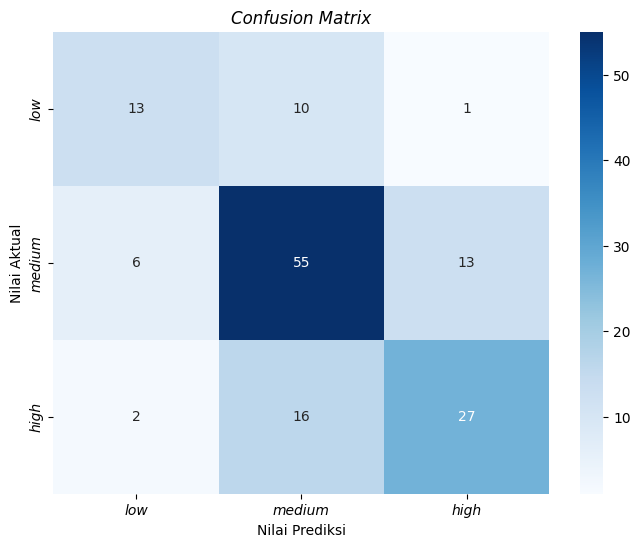

In [32]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

# y_true = dataset['test']['label']

# Define your desired order
label_order = ['low', 'medium', 'high']
label_to_int = {label: i for i, label in enumerate(label_order)}

# Map labels to integers using the custom order
y_true_encoded = [label_to_int[label] for label in y_true]
y_pred_new_encoded = [label_to_int[label] for label in final_predictions]

# Print classification report
print(classification_report(y_true_encoded, y_pred_new_encoded, target_names=label_order))

# Generate confusion matrix
cm = confusion_matrix(y_true_encoded, y_pred_new_encoded)

# Create a heatmap for the confusion matrix
plt.figure(figsize=(8, 6))
# sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=label_order, yticklabels=label_order)

ax = sns.heatmap(
    cm, annot=True, fmt="d", cmap="Blues",
    xticklabels=label_order, yticklabels=label_order
)

# Italicize all xticks and yticks
for label in ax.get_xticklabels() + ax.get_yticklabels():
    label.set_fontstyle("italic")
    
# plt.xlabel('Predicted')
plt.xlabel('Nilai Prediksi')
# plt.ylabel('True')
plt.ylabel('Nilai Aktual')
plt.title('Confusion Matrix', fontstyle='italic')
# plt.show()
plt.savefig('_plot_result/severity_conf_matrix.pdf', format='pdf', dpi=1000)

              precision    recall  f1-score   support

         low     0.6190    0.5417    0.5778        24
      medium     0.6790    0.7432    0.7097        74
        high     0.6585    0.6000    0.6279        45

    accuracy                         0.6643       143
   macro avg     0.6522    0.6283    0.6385       143
weighted avg     0.6625    0.6643    0.6618       143



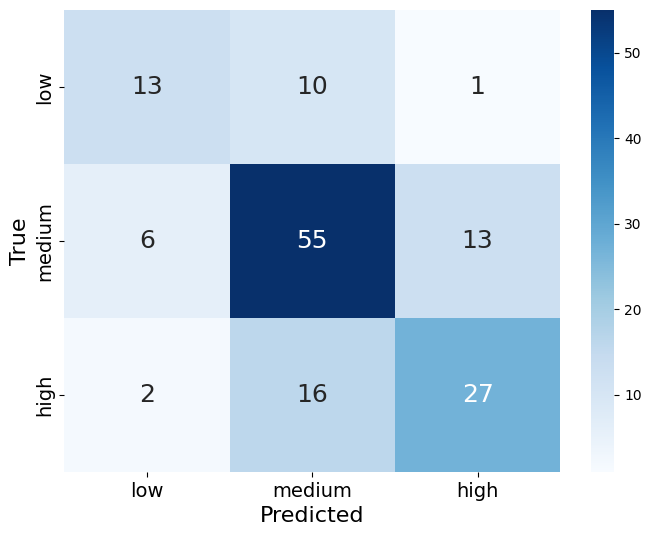

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

# y_true = dataset['test']['label']

# Define your desired order
label_order = ['low', 'medium', 'high']
label_to_int = {label: i for i, label in enumerate(label_order)}

# Map labels to integers using the custom order
y_true_encoded = [label_to_int[label] for label in y_true]
y_pred_new_encoded = [label_to_int[label] for label in final_predictions]

# Print classification report
print(classification_report(y_true_encoded, y_pred_new_encoded, target_names=label_order, digits=4))

# Generate confusion matrix
cm = confusion_matrix(y_true_encoded, y_pred_new_encoded)

# Create a heatmap for the confusion matrix
plt.figure(figsize=(8, 6))
# sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=label_order, yticklabels=label_order)

ax = sns.heatmap(
    cm, annot=True, fmt="d", cmap="Blues",
    xticklabels=label_order, yticklabels=label_order,
    annot_kws={"size": 18}
)

# # Italicize all xticks and yticks
# for label in ax.get_xticklabels() + ax.get_yticklabels():
#     label.set_fontstyle("italic")

# Italicize all xticks and yticks
for label in ax.get_xticklabels() + ax.get_yticklabels():
    label.set_fontsize(14)
    
plt.xlabel('Predicted', fontsize=16)
# plt.xlabel('Nilai Prediksi')
plt.ylabel('True', fontsize=16)
# plt.ylabel('Nilai Aktual')
# plt.title('Confusion Matrix', fontstyle='italic')
# plt.title('Confusion Matrix', fontsize=18)
# plt.show()
plt.savefig('_plot_result/severity_conf_matrix_eng.pdf', format='pdf', dpi=1000)

In [61]:
import numpy as np
from sklearn.metrics import classification_report

def classification_report_dict_from_confusion_matrix(cm, target_names=None, digits=4):
    """
    Generate sklearn-like classification report (dict) from a confusion matrix of any size (NxN).

    Args:
        cm (list or np.ndarray): square confusion matrix (e.g. [[13,10,1],[6,55,13],[2,16,27]])
        target_names (list): optional list of class labels, length = N
        digits (int): decimal precision for metrics
    
    Returns:
        dict: keys = each class name + 'accuracy', 'macro avg', 'weighted avg'
              each class entry has precision, recall, f1‑score, support
    """
    cm = np.array(cm, dtype=int)
    if cm.ndim != 2 or cm.shape[0] != cm.shape[1]:
        raise ValueError("Confusion matrix must be square (NxN).")
    n = cm.shape[0]
    if target_names is None:
        target_names = [f'class_{i}' for i in range(n)]
    elif len(target_names) != n:
        raise ValueError("target_names length must match matrix size")

    # Reconstruct y_true and y_pred
    total = cm.sum()
    y_true = np.empty(total, dtype=int)
    y_pred = np.empty(total, dtype=int)
    idx = 0
    for actual in range(n):
        for pred in range(n):
            count = cm[actual, pred]
            if count > 0:
                y_true[idx:idx+count] = actual
                y_pred[idx:idx+count] = pred
                idx += count

    # Generate sklearn classification report dict
    report = classification_report(
        y_true, y_pred,
        labels=list(range(n)),
        target_names=target_names,
        digits=digits
    )
    return report

In [43]:
# CodeBERT

cm = [[12,12,0],[6,55,13],[0,27,18]]
print(classification_report_dict_from_confusion_matrix(cm))

              precision    recall  f1-score   support

     class_0     0.6667    0.5000    0.5714        24
     class_1     0.5851    0.7432    0.6548        74
     class_2     0.5806    0.4000    0.4737        45

    accuracy                         0.5944       143
   macro avg     0.6108    0.5477    0.5666       143
weighted avg     0.5974    0.5944    0.5838       143



In [44]:
# GraphCodeBERT

cm = [[13,9,2],[9,53,12],[2,29,14]]
print(classification_report_dict_from_confusion_matrix(cm))

              precision    recall  f1-score   support

     class_0     0.5417    0.5417    0.5417        24
     class_1     0.5824    0.7162    0.6424        74
     class_2     0.5000    0.3111    0.3836        45

    accuracy                         0.5594       143
   macro avg     0.5414    0.5230    0.5226       143
weighted avg     0.5496    0.5594    0.5441       143



In [46]:
# CodeT5

cm = [[13,9,2],[11,43,20],[1,30,14]]
print(classification_report_dict_from_confusion_matrix(cm))

              precision    recall  f1-score   support

     class_0     0.5200    0.5417    0.5306        24
     class_1     0.5244    0.5811    0.5513        74
     class_2     0.3889    0.3111    0.3457        45

    accuracy                         0.4895       143
   macro avg     0.4778    0.4780    0.4759       143
weighted avg     0.4810    0.4895    0.4831       143



In [45]:
# UnixCoder

cm = [[12,8,4],[5,48,21],[0,19,26]]
print(classification_report_dict_from_confusion_matrix(cm))

              precision    recall  f1-score   support

     class_0     0.7059    0.5000    0.5854        24
     class_1     0.6400    0.6486    0.6443        74
     class_2     0.5098    0.5778    0.5417        45

    accuracy                         0.6014       143
   macro avg     0.6186    0.5755    0.5904       143
weighted avg     0.6101    0.6014    0.6021       143



In [62]:
# CodeLlama

cm = [[22,0,23],[0,15,9],[15,7,52]]
print(classification_report_dict_from_confusion_matrix(cm))

              precision    recall  f1-score   support

     class_0     0.5946    0.4889    0.5366        45
     class_1     0.6818    0.6250    0.6522        24
     class_2     0.6190    0.7027    0.6582        74

    accuracy                         0.6224       143
   macro avg     0.6318    0.6055    0.6157       143
weighted avg     0.6219    0.6224    0.6189       143



In [ ]:
import pandas as pd

df_verif_gpt_4o = pd.read_csv("zeroshot_gpt4o.csv")
df_verif_zeroshot_codellama13b = pd.read_csv("zeroshot_exp_codellama13b.csv")
df_verif_zeroshot_codellama34b = pd.read_csv("zeroshot_exp_codellama34b.csv")
df_verif_finetuned_codellama13b = pd.read_csv("sft_codellama13b_vuln_exp.csv")

In [ ]:
import pandas as pd
import pickle

df_combined = pd.read_csv("vuln_combination.csv")

def extract_answer(text: str) -> str | None:
    answer = text.split("</think>\n\n")[-1]
    return answer.strip()

df_combined['final_output'] = df_combined['final_output'].apply(extract_answer)

In [ ]:
import re
from unsloth import FastLanguageModel
from unsloth.chat_templates import get_chat_template

VERIFIER_SYSTEM_PROMPT = """You are an **LLM Validator** that strictly responds with either **0 or 1**.
- You must only base your judgment on the provided ground truth context.
- Do **not** assume, infer, or speculate beyond what is explicitly stated in the ground truth.
- Do **not** provide any explanations, justifications, or output anything other than **0** or **1**."""

VERIFIER_USER_PROMPT = """Given the predicted vulnerability explanation from the LLM and the ground truth vulnerability in the context, evaluate whether the predicted vulnerability actually exists **exactly as described** in the context.

**Scoring Rules:**
- Respond with **1** only if:
  - The LLM output describes a vulnerability that is explicitly and clearly present in the ground truth context.
  - The LLM output does **not** introduce any vulnerabilities, risks, or attack scenarios that are not described in the context.

- Respond with **0** if:
  - The LLM output includes any vulnerability or explanation that is **not present** in the ground truth.
  - The LLM output makes assumptions, hallucinations, or adds unrelated or speculative information.

**Respond strictly with:**  
- **0** or  
- **1**

**LLM Output:**  
{llm_output}  

**Ground Truth Context:**  
{ground_truth}"""

verifier_model_name = "unsloth/Qwen3-14B-unsloth-bnb-4bit"
verifier_max_seq_length = 32768  # Adjust based on your requirements
verifier_load_in_4bit = True # Use 4bit quantization to reduce memory usage. Can be False.

verifier_model, verifier_tokenizer = FastLanguageModel.from_pretrained(
    model_name=verifier_model_name,
    load_in_4bit = verifier_load_in_4bit,
    max_seq_length=verifier_max_seq_length,
)

FastLanguageModel.for_inference(verifier_model) # Enable native 2x faster inference


def llm_verifier(llm_output, ground_truth):
    messages = [
        {"role": "system", "content": VERIFIER_SYSTEM_PROMPT},
        {"role": "system", "content": VERIFIER_USER_PROMPT.format(llm_output=llm_output, ground_truth=ground_truth)},
    ]
    
    # Tokenize input
    inputs = verifier_tokenizer.apply_chat_template(
        messages, tokenize=True, add_generation_prompt=True, return_tensors="pt", enable_thinking=False
    ).to("cuda")

    # Generate response
    outputs = verifier_model.generate(
        input_ids=inputs,
        max_new_tokens=2,
        use_cache=True,
        temperature = 0.1, 
        min_p = 0.1
    )

    # Decode response
    generated_text = outputs[0][inputs.shape[1]:]  
    verifier_response = verifier_tokenizer.decode(generated_text, skip_special_tokens=True).strip()
    
    # Search for a '0' or '1' anywhere in the response
    match = re.search(r'[01]', verifier_response)
    if match:
        return int(match.group(0))  # Return as integer (either 0 or 1)
    else:
        raise ValueError(f"Invalid response from verifier model: {verifier_response}. Expected '0' or '1'.")

/usr/local/lib/python3.10/dist-packages/torch/utils/_pytree.py:185: FutureWarning: optree is installed but the version is too old to support PyTorch Dynamo in C++ pytree. C++ pytree support is disabled. Please consider upgrading optree using `python3 -m pip install --upgrade 'optree>=0.13.0'`.
  warnings.warn(


🦥 Unsloth: Will patch your computer to enable 2x faster free finetuning.


/usr/local/lib/python3.10/dist-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


🦥 Unsloth Zoo will now patch everything to make training faster!


/usr/local/lib/python3.10/dist-packages/torch/utils/_pytree.py:185: FutureWarning: optree is installed but the version is too old to support PyTorch Dynamo in C++ pytree. C++ pytree support is disabled. Please consider upgrading optree using `python3 -m pip install --upgrade 'optree>=0.13.0'`.
  warnings.warn(


INFO 06-12 09:20:35 [importing.py:53] Triton module has been replaced with a placeholder.
INFO 06-12 09:20:35 [__init__.py:239] Automatically detected platform cuda.


2025-06-12 09:20:38,059	INFO util.py:154 -- Missing packages: ['ipywidgets']. Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.


==((====))==  Unsloth 2025.5.3: Fast Qwen3 patching. Transformers: 4.51.3. vLLM: 0.8.5.
   \\   /|    Tesla V100-SXM2-32GB. Num GPUs = 1. Max memory: 31.749 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.6.0+cu124. CUDA: 7.0. CUDA Toolkit: 12.4. Triton: 3.2.0
\        /    Bfloat16 = FALSE. FA [Xformers = 0.0.29.post2. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


Loading checkpoint shards: 100%|██████████| 3/3 [00:03<00:00,  1.28s/it]


In [19]:
import re
from tqdm import tqdm  # Import tqdm for progress bar

# Initialize the result collection
results = []

for item, row in tqdm(df_combined.iterrows(), total=len(df_combined), desc="Processing dataset"):
    llm_output = row['final_output']
    ground_truth = row['ground_truth']
    
    # Run the llm_verifier function for the current entry
    try:
        verification_result = llm_verifier(llm_output, ground_truth)
        results.append({
            "vuln_code": row['vuln_code'],
            "llm_output": row['final_output'],
            "ground_truth": row['ground_truth'],
            "verification_result": verification_result
        })
    except ValueError as e:
        # Handle invalid responses if necessary
        print(f"Error processing entry {row['vuln_code']}: {e}")
        results.append({
            "vuln_code": row['vuln_code'],
            "verification_result": None
        })

# After the loop, you can convert the results list to a DataFrame or another suitable format if needed
verification_results_df = pd.DataFrame(results)

Processing dataset: 100%|██████████| 143/143 [01:13<00:00,  1.96it/s]


In [23]:
verification_results_df['verification_result'].value_counts(normalize=True)

0    0.748252
1    0.251748
Name: verification_result, dtype: float64

In [22]:
import re
from tqdm import tqdm  # Import tqdm for progress bar

# Initialize the result collection
results = []

for item, row in tqdm(df_verif_gpt_4o.iterrows(), total=len(df_combined), desc="Processing dataset"):
    llm_output = row['llm_output']
    ground_truth = row['ground_truth']
    
    # Run the llm_verifier function for the current entry
    try:
        verification_result = llm_verifier(llm_output, ground_truth)
        results.append({
            "vuln_code": row['vuln_code'],
            "llm_output": row['llm_output'],
            "ground_truth": row['ground_truth'],
            "verification_result": verification_result
        })
    except ValueError as e:
        # Handle invalid responses if necessary
        print(f"Error processing entry {row['vuln_code']}: {e}")
        results.append({
            "vuln_code": row['vuln_code'],
            "verification_result": None
        })

# After the loop, you can convert the results list to a DataFrame or another suitable format if needed
verification_results_df_gpt4o = pd.DataFrame(results)

Processing dataset: 100%|██████████| 143/143 [01:20<00:00,  1.78it/s]


In [24]:
verification_results_df_gpt4o['verification_result'].value_counts(normalize=True)

0    0.79021
1    0.20979
Name: verification_result, dtype: float64

In [25]:
import re
from tqdm import tqdm  # Import tqdm for progress bar

# Initialize the result collection
results = []

for item, row in tqdm(df_verif_zeroshot_codellama13b.iterrows(), total=len(df_combined), desc="Processing dataset"):
    llm_output = row['llm_output']
    ground_truth = row['ground_truth']
    
    # Run the llm_verifier function for the current entry
    try:
        verification_result = llm_verifier(llm_output, ground_truth)
        results.append({
            "vuln_code": row['vuln_code'],
            "llm_output": row['llm_output'],
            "ground_truth": row['ground_truth'],
            "verification_result": verification_result
        })
    except ValueError as e:
        # Handle invalid responses if necessary
        print(f"Error processing entry {row['vuln_code']}: {e}")
        results.append({
            "vuln_code": row['vuln_code'],
            "verification_result": None
        })

# After the loop, you can convert the results list to a DataFrame or another suitable format if needed
verification_results_df_zeroshot_codellama13b = pd.DataFrame(results)

Processing dataset: 100%|██████████| 143/143 [01:26<00:00,  1.66it/s]


In [26]:
verification_results_df_zeroshot_codellama13b['verification_result'].value_counts(normalize=True)

0    0.958042
1    0.041958
Name: verification_result, dtype: float64

In [27]:
import re
from tqdm import tqdm  # Import tqdm for progress bar

# Initialize the result collection
results = []

for item, row in tqdm(df_verif_zeroshot_codellama34b.iterrows(), total=len(df_combined), desc="Processing dataset"):
    llm_output = row['llm_output']
    ground_truth = row['ground_truth']
    
    # Run the llm_verifier function for the current entry
    try:
        verification_result = llm_verifier(llm_output, ground_truth)
        results.append({
            "vuln_code": row['vuln_code'],
            "llm_output": row['llm_output'],
            "ground_truth": row['ground_truth'],
            "verification_result": verification_result
        })
    except ValueError as e:
        # Handle invalid responses if necessary
        print(f"Error processing entry {row['vuln_code']}: {e}")
        results.append({
            "vuln_code": row['vuln_code'],
            "verification_result": None
        })

# After the loop, you can convert the results list to a DataFrame or another suitable format if needed
verification_results_df_zeroshot_codellama34b = pd.DataFrame(results)

Processing dataset: 100%|██████████| 143/143 [01:38<00:00,  1.46it/s]


In [28]:
verification_results_df_zeroshot_codellama34b['verification_result'].value_counts(normalize=True)

0    0.867133
1    0.132867
Name: verification_result, dtype: float64

In [29]:
import re
from tqdm import tqdm  # Import tqdm for progress bar

# Initialize the result collection
results = []

for item, row in tqdm(df_verif_finetuned_codellama13b.iterrows(), total=len(df_combined), desc="Processing dataset"):
    llm_output = row['llm_output']
    ground_truth = row['ground_truth']
    
    # Run the llm_verifier function for the current entry
    try:
        verification_result = llm_verifier(llm_output, ground_truth)
        results.append({
            "vuln_code": row['vuln_code'],
            "llm_output": row['llm_output'],
            "ground_truth": row['ground_truth'],
            "verification_result": verification_result
        })
    except ValueError as e:
        # Handle invalid responses if necessary
        print(f"Error processing entry {row['vuln_code']}: {e}")
        results.append({
            "vuln_code": row['vuln_code'],
            "verification_result": None
        })

# After the loop, you can convert the results list to a DataFrame or another suitable format if needed
verification_results_df_finetuned_codellama13b = pd.DataFrame(results)

Processing dataset: 100%|██████████| 143/143 [01:13<00:00,  1.93it/s]


In [30]:
verification_results_df_finetuned_codellama13b['verification_result'].value_counts(normalize=True)

0    0.832168
1    0.167832
Name: verification_result, dtype: float64

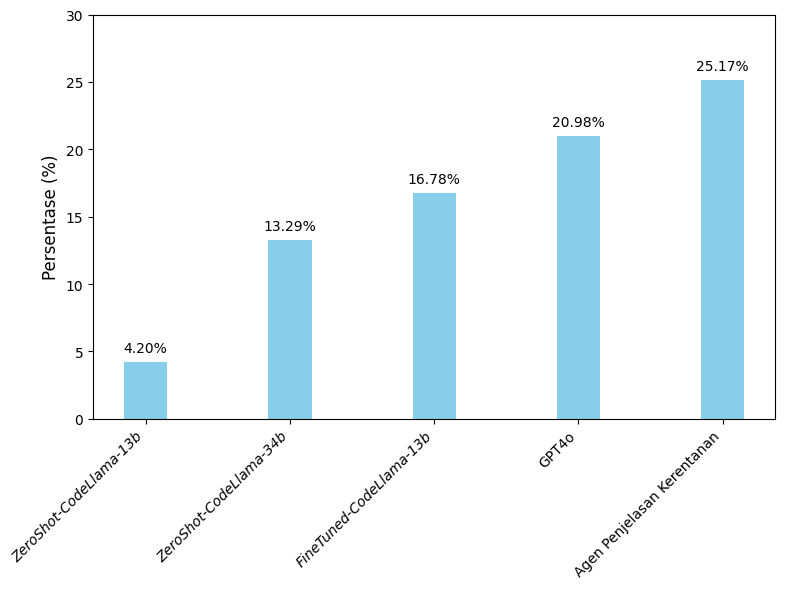

In [ ]:
import matplotlib.pyplot as plt

# Data
categories = ['ZeroShot-CodeLlama-13b', 'ZeroShot-CodeLlama-34b', 'FineTuned-CodeLlama-13b', 'GPT4o', 'Agen Penjelasan Kerentanan']
percentages = [4.20, 13.29, 16.78, 20.98, 25.17]

# Create the bar plot
plt.figure(figsize=(8, 6))
bars = plt.bar(categories, percentages, color='skyblue', width=0.3)

# Add percentage labels on top of each bar
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.5, f'{yval:.2f}%', 
             ha='center', va='bottom', fontsize=10)

# Customize the plot
# plt.ylabel('Percentage (%)', fontsize=12)
plt.ylabel('Persentase (%)', fontsize=12)
plt.ylim(0, 30)  # Set y-axis limit to accommodate the highest value
plt.xticks(rotation=45, ha='right')
plt.tight_layout()  # Adjust layout to prevent clipping

# Italicize only the first 3 xtick labels
ax = plt.gca()
for i, label in enumerate(ax.get_xticklabels()):
    if i < 3:  # first three labels
        label.set_fontstyle('italic')

# Display the plot
# plt.show()
plt.savefig('_plot_result/percentage_vuln_exp.pdf', format='pdf', dpi=1000)

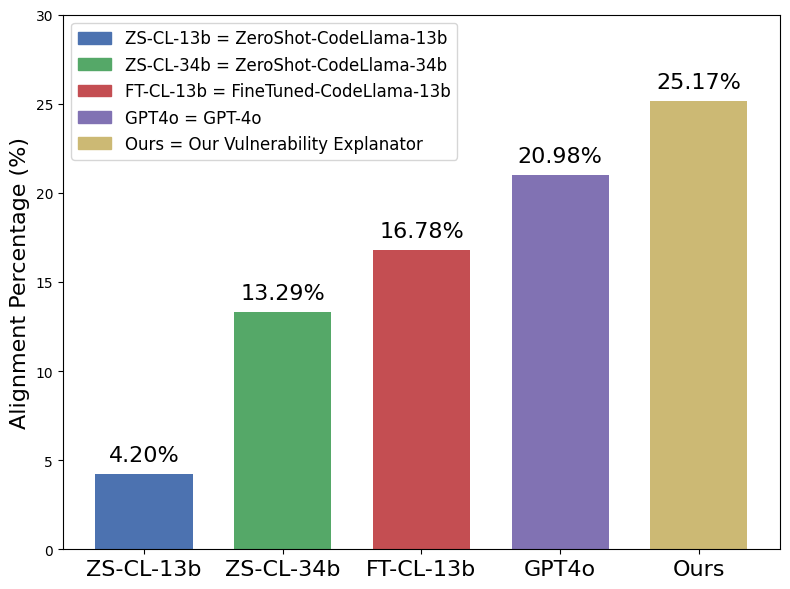

In [10]:
import matplotlib.pyplot as plt

# Data
categories = ['ZS-CL-13b', 'ZS-CL-34b', 'FT-CL-13b', 'GPT4o', 'Ours']
percentages = [4.20, 13.29, 16.78, 20.98, 25.17]

# Mapping abbreviations to their full names
abbr_meanings = {
    'ZS-CL-13b': 'ZeroShot-CodeLlama-13b',
    'ZS-CL-34b': 'ZeroShot-CodeLlama-34b',
    'FT-CL-13b': 'FineTuned-CodeLlama-13b',
    'GPT4o': 'GPT-4o',
    'Ours': 'Our Vulnerability Explanator'
}

# Colors for each bar
colors = ['#4C72B0', '#55A868', '#C44E52', '#8172B3', '#CCB974']

# Create the bar plot
plt.figure(figsize=(8, 6))
bars = plt.bar(categories, percentages, color=colors, width=0.7)

# Add percentage labels on top of each bar
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.5, f'{yval:.2f}%', 
             ha='center', va='bottom', fontsize=16)

# Customize the plot
plt.ylabel('Alignment Percentage (%)', fontsize=16)
plt.ylim(0, 30)  # Set y-axis limit to accommodate the highest value
# plt.xticks(rotation=45, ha='right')
plt.xticks(fontsize=16)
plt.tight_layout()  # Adjust layout to prevent clipping

# Add legend inside the plot
legend_handles = [plt.Rectangle((0,0),1,1, color=colors[i]) for i in range(len(categories))]
legend_labels = [f"{abbr} = {abbr_meanings[abbr]}" for abbr in categories]
plt.legend(legend_handles, legend_labels, loc='upper left', fontsize=12, frameon=True)

# Save or show
plt.savefig('_plot_result/percentage_vuln_exp_eng.pdf', format='pdf', dpi=1000, bbox_inches='tight')
# plt.show()

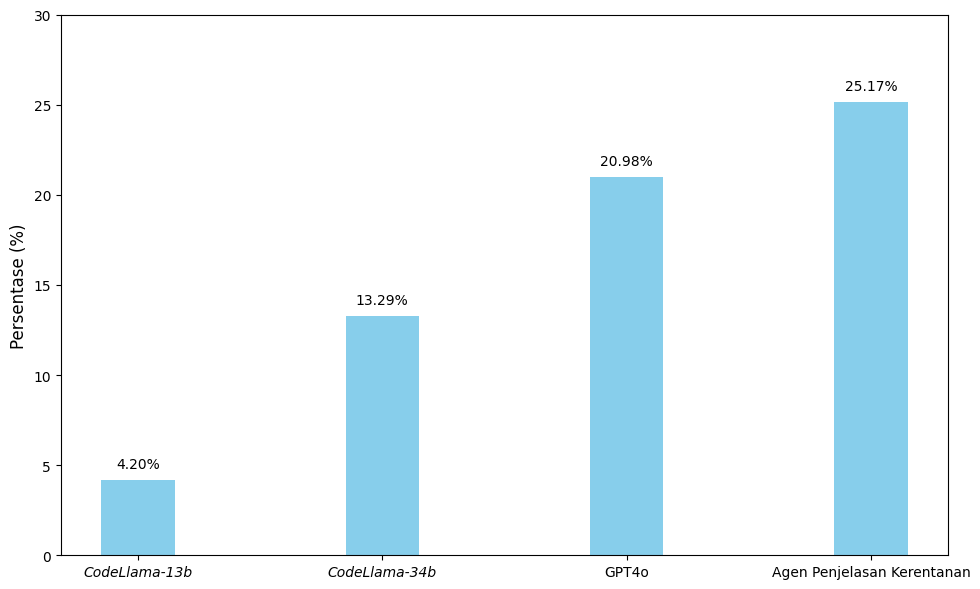

In [ ]:
import matplotlib.pyplot as plt

# Data
categories = ['CodeLlama-13b', 'CodeLlama-34b', 'GPT4o', 'Agen Penjelasan Kerentanan']
percentages = [4.20, 13.29, 20.98, 25.17]

# Create the bar plot
plt.figure(figsize=(10, 6))
bars = plt.bar(categories, percentages, color='skyblue', width=0.3)

# Add percentage labels on top of each bar
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.5, f'{yval:.2f}%', 
             ha='center', va='bottom', fontsize=10)

# Customize the plot
# plt.ylabel('Percentage (%)', fontsize=12)
plt.ylabel('Persentase (%)', fontsize=12)
plt.ylim(0, 30)  # Set y-axis limit to accommodate the highest value
# plt.xticks(rotation=45, ha='right')
plt.tight_layout()  # Adjust layout to prevent clipping

# Italicize only the first 3 xtick labels
ax = plt.gca()
for i, label in enumerate(ax.get_xticklabels()):
    if i < 2:  # first three labels
        label.set_fontstyle('italic')

# Display the plot
# plt.show()
plt.savefig('_plot_result/percentage_vuln_exp_temp.pdf', format='pdf', dpi=1000)

In [ ]:
import pandas as pd

df_combined = pd.read_csv("final_recom_eval.csv")
df_codellama34b = pd.read_csv("zeroshot_codellama34b_recommendation.csv")
df_codellama13b = pd.read_csv("zeroshot_codellama13b_recommendation.csv")
df_codellama13b_finetuned = pd.read_csv("sft_codellama13b_recommendation.csv")
df_gpt4o = pd.read_csv("zeroshot_gpt4o_recom.csv")

In [ ]:
import re
from unsloth import FastLanguageModel
from unsloth.chat_templates import get_chat_template

VERIFIER_SYSTEM_PROMPT = """You are an **LLM Validator** that strictly responds with either **0 or 1**.
- You must only base your judgment on the provided ground truth context.
- Do **not** assume, infer, or speculate beyond what is explicitly stated in the ground truth.
- Do **not** provide any explanations, justifications, or output anything other than **0** or **1**."""

VERIFIER_USER_PROMPT = """Given the predicted recommendation from the LLM and the ground truth recommendation in the context, evaluate whether the predicted recommendation exists **exactly as described** in the context.

**Scoring Rules:**
- Respond with **1** only if:
  - The LLM output describes a recommendation that is explicitly and clearly present in the ground truth context.
  - The LLM output does **not** introduce any recommendation that are not described in the context.

- Respond with **0** if:
  - The LLM output includes any recommendation that is **not present** in the ground truth.
  - The LLM output makes assumptions, hallucinations, or adds unrelated or speculative information.

**Respond strictly with:**  
- **0** or  
- **1**

**LLM Output:**  
{llm_output}  

**Ground Truth Context:**  
{ground_truth}"""

verifier_model_name = "unsloth/Qwen3-14B-unsloth-bnb-4bit"
verifier_max_seq_length = 32768  # Adjust based on your requirements
verifier_load_in_4bit = True # Use 4bit quantization to reduce memory usage. Can be False.

verifier_model, verifier_tokenizer = FastLanguageModel.from_pretrained(
    model_name=verifier_model_name,
    load_in_4bit = verifier_load_in_4bit,
    max_seq_length=verifier_max_seq_length,
)

FastLanguageModel.for_inference(verifier_model) # Enable native 2x faster inference


def llm_verifier(llm_output, ground_truth):
    messages = [
        {"role": "system", "content": VERIFIER_SYSTEM_PROMPT},
        {"role": "system", "content": VERIFIER_USER_PROMPT.format(llm_output=llm_output, ground_truth=ground_truth)},
    ]
    
    # Tokenize input
    inputs = verifier_tokenizer.apply_chat_template(
        messages, tokenize=True, add_generation_prompt=True, return_tensors="pt", enable_thinking=False
    ).to("cuda")

    # Generate response
    outputs = verifier_model.generate(
        input_ids=inputs,
        max_new_tokens=2,
        use_cache=True,
        temperature = 0.1, 
        min_p = 0.1
    )

    # Decode response
    generated_text = outputs[0][inputs.shape[1]:]  
    verifier_response = verifier_tokenizer.decode(generated_text, skip_special_tokens=True).strip()
    
    # Search for a '0' or '1' anywhere in the response
    match = re.search(r'[01]', verifier_response)
    if match:
        return int(match.group(0))  # Return as integer (either 0 or 1)
    else:
        raise ValueError(f"Invalid response from verifier model: {verifier_response}. Expected '0' or '1'.")


==((====))==  Unsloth 2025.5.3: Fast Qwen3 patching. Transformers: 4.51.3. vLLM: 0.8.5.
   \\   /|    Tesla V100-SXM2-32GB. Num GPUs = 1. Max memory: 31.749 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.6.0+cu124. CUDA: 7.0. CUDA Toolkit: 12.4. Triton: 3.2.0
\        /    Bfloat16 = FALSE. FA [Xformers = 0.0.29.post2. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


Loading checkpoint shards: 100%|██████████| 3/3 [00:03<00:00,  1.16s/it]


In [20]:
import re
from tqdm import tqdm  # Import tqdm for progress bar

# Initialize the result collection
results = []

for item, row in tqdm(df_combined.iterrows(), total=len(df_combined), desc="Processing dataset"):
    llm_output = row['final_output']
    ground_truth = row['ground_truth']
    
    # Run the llm_verifier function for the current entry
    try:
        verification_result = llm_verifier(llm_output, ground_truth)
        results.append({
            "vuln_code": row['vuln_code'],
            "llm_output": row['final_output'],
            "ground_truth": row['ground_truth'],
            "verification_result": verification_result
        })
    except ValueError as e:
        # Handle invalid responses if necessary
        print(f"Error processing entry {row['vuln_code']}: {e}")
        results.append({
            "vuln_code": row['vuln_code'],
            "verification_result": None
        })

# After the loop, you can convert the results list to a DataFrame or another suitable format if needed
verification_results_df = pd.DataFrame(results)

Processing dataset: 100%|██████████| 143/143 [02:16<00:00,  1.05it/s]


In [21]:
verification_results_df['verification_result'].value_counts(normalize=True)

1    0.531469
0    0.468531
Name: verification_result, dtype: float64

In [22]:
import re
from tqdm import tqdm  # Import tqdm for progress bar

# Initialize the result collection
results = []

for item, row in tqdm(df_codellama13b.iterrows(), total=len(df_combined), desc="Processing dataset"):
    llm_output = row['llm_output']
    ground_truth = row['ground_truth']
    
    # Run the llm_verifier function for the current entry
    try:
        verification_result = llm_verifier(llm_output, ground_truth)
        results.append({
            "vuln_code": row['vuln_code'],
            "llm_output": row['llm_output'],
            "ground_truth": row['ground_truth'],
            "verification_result": verification_result
        })
    except ValueError as e:
        # Handle invalid responses if necessary
        print(f"Error processing entry {row['vuln_code']}: {e}")
        results.append({
            "vuln_code": row['vuln_code'],
            "verification_result": None
        })

# After the loop, you can convert the results list to a DataFrame or another suitable format if needed
verification_results_df_codellama13b = pd.DataFrame(results)

Processing dataset: 100%|██████████| 143/143 [01:05<00:00,  2.19it/s]


In [23]:
verification_results_df_codellama13b['verification_result'].value_counts(normalize=True)

0    0.895105
1    0.104895
Name: verification_result, dtype: float64

In [24]:
import re
from tqdm import tqdm  # Import tqdm for progress bar

# Initialize the result collection
results = []

for item, row in tqdm(df_codellama34b.iterrows(), total=len(df_combined), desc="Processing dataset"):
    llm_output = row['llm_output']
    ground_truth = row['ground_truth']
    
    # Run the llm_verifier function for the current entry
    try:
        verification_result = llm_verifier(llm_output, ground_truth)
        results.append({
            "vuln_code": row['vuln_code'],
            "llm_output": row['llm_output'],
            "ground_truth": row['ground_truth'],
            "verification_result": verification_result
        })
    except ValueError as e:
        # Handle invalid responses if necessary
        print(f"Error processing entry {row['vuln_code']}: {e}")
        results.append({
            "vuln_code": row['vuln_code'],
            "verification_result": None
        })

# After the loop, you can convert the results list to a DataFrame or another suitable format if needed
verification_results_df_codellama34b = pd.DataFrame(results)

Processing dataset: 100%|██████████| 143/143 [01:04<00:00,  2.23it/s]


In [25]:
verification_results_df_codellama34b['verification_result'].value_counts(normalize=True)

0    0.86014
1    0.13986
Name: verification_result, dtype: float64

In [26]:
import re
from tqdm import tqdm  # Import tqdm for progress bar

# Initialize the result collection
results = []

for item, row in tqdm(df_codellama13b_finetuned.iterrows(), total=len(df_combined), desc="Processing dataset"):
    llm_output = row['llm_output']
    ground_truth = row['ground_truth']
    
    # Run the llm_verifier function for the current entry
    try:
        verification_result = llm_verifier(llm_output, ground_truth)
        results.append({
            "vuln_code": row['vuln_code'],
            "llm_output": row['llm_output'],
            "ground_truth": row['ground_truth'],
            "verification_result": verification_result
        })
    except ValueError as e:
        # Handle invalid responses if necessary
        print(f"Error processing entry {row['vuln_code']}: {e}")
        results.append({
            "vuln_code": row['vuln_code'],
            "verification_result": None
        })

# After the loop, you can convert the results list to a DataFrame or another suitable format if needed
verification_results_codellama13b_finetuned = pd.DataFrame(results)

Processing dataset: 100%|██████████| 143/143 [01:04<00:00,  2.22it/s]


In [27]:
verification_results_codellama13b_finetuned['verification_result'].value_counts(normalize=True)

1    0.503497
0    0.496503
Name: verification_result, dtype: float64

In [28]:
import re
from tqdm import tqdm  # Import tqdm for progress bar

# Initialize the result collection
results = []

for item, row in tqdm(df_gpt4o.iterrows(), total=len(df_combined), desc="Processing dataset"):
    llm_output = row['llm_output']
    ground_truth = row['ground_truth']
    
    # Run the llm_verifier function for the current entry
    try:
        verification_result = llm_verifier(llm_output, ground_truth)
        results.append({
            "vuln_code": row['vuln_code'],
            "llm_output": row['llm_output'],
            "ground_truth": row['ground_truth'],
            "verification_result": verification_result
        })
    except ValueError as e:
        # Handle invalid responses if necessary
        print(f"Error processing entry {row['vuln_code']}: {e}")
        results.append({
            "vuln_code": row['vuln_code'],
            "verification_result": None
        })

# After the loop, you can convert the results list to a DataFrame or another suitable format if needed
verification_results_gpt4o = pd.DataFrame(results)

Processing dataset: 100%|██████████| 143/143 [01:06<00:00,  2.15it/s]


In [29]:
verification_results_gpt4o['verification_result'].value_counts(normalize=True)

0    0.671329
1    0.328671
Name: verification_result, dtype: float64

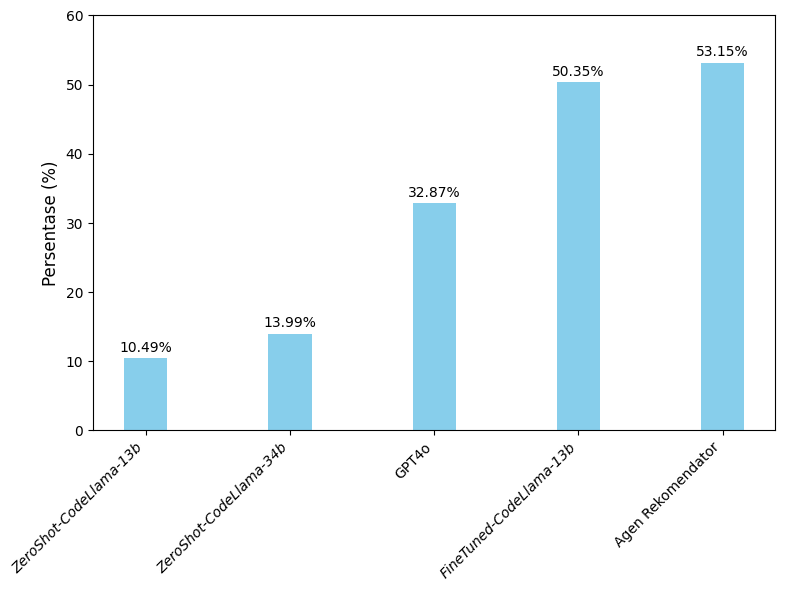

In [57]:
import matplotlib.pyplot as plt

# Data
# categories = ['CodeLlama-13b', 'CodeLlama-34b', 'GPT4o', 'GPT4.1', 'Ours']
# categories = ['CodeLlama-13b', 'GPT4o', 'GPT4.1', 'Ours']
categories = ['ZeroShot-CodeLlama-13b', 'ZeroShot-CodeLlama-34b', 'GPT4o', 'FineTuned-CodeLlama-13b', 'Agen Rekomendator']
percentages = [10.49, 13.99, 32.87, 50.35, 53.15]

# Create the bar plot
plt.figure(figsize=(8, 6))
bars = plt.bar(categories, percentages, color='skyblue', width=0.3)

# Add percentage labels on top of each bar
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.5, f'{yval:.2f}%', 
             ha='center', va='bottom', fontsize=10)

# Customize the plot
# plt.ylabel('Percentage (%)', fontsize=12)
plt.ylabel('Persentase (%)', fontsize=12)
plt.ylim(0, 60)  # Set y-axis limit to accommodate the highest value
plt.xticks(rotation=45, ha='right')
plt.tight_layout()  # Adjust layout to prevent clipping

# Italicize only the first 3 xtick labels
ax = plt.gca()
for i, label in enumerate(ax.get_xticklabels()):
    if i < 2:  # first three labels
        label.set_fontstyle('italic')
    if i == 3:
        label.set_fontstyle('italic')

# Display the plot
# plt.show()
plt.savefig('_plot_result/percentage_recommendation.pdf', format='pdf', dpi=1000)

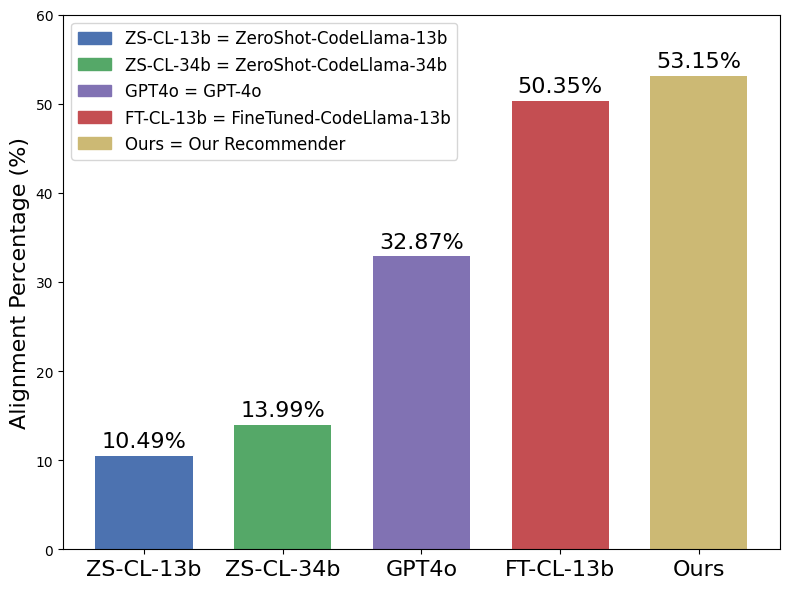

In [12]:
import matplotlib.pyplot as plt

# Data
categories = ['ZS-CL-13b', 'ZS-CL-34b', 'GPT4o', 'FT-CL-13b', 'Ours']
percentages = [10.49, 13.99, 32.87, 50.35, 53.15]

# Mapping abbreviations to their full names
abbr_meanings = {
    'ZS-CL-13b': 'ZeroShot-CodeLlama-13b',
    'ZS-CL-34b': 'ZeroShot-CodeLlama-34b',
    'FT-CL-13b': 'FineTuned-CodeLlama-13b',
    'GPT4o': 'GPT-4o',
    'Ours': 'Our Recommender'
}

# Colors for each bar
colors = ['#4C72B0', '#55A868', '#8172B3', '#C44E52', '#CCB974']

# Create the bar plot
plt.figure(figsize=(8, 6))
bars = plt.bar(categories, percentages, color=colors, width=0.7)

# Add percentage labels on top of each bar
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.5, f'{yval:.2f}%', 
             ha='center', va='bottom', fontsize=16)

# Customize the plot
plt.ylabel('Alignment Percentage (%)', fontsize=16)
plt.ylim(0, 60)  # Set y-axis limit to accommodate the highest value
# plt.xticks(rotation=45, ha='right')
plt.xticks(fontsize=16)
plt.tight_layout()  # Adjust layout to prevent clipping

# Add legend inside the plot
legend_handles = [plt.Rectangle((0,0),1,1, color=colors[i]) for i in range(len(categories))]
legend_labels = [f"{abbr} = {abbr_meanings[abbr]}" for abbr in categories]
plt.legend(legend_handles, legend_labels, loc='upper left', fontsize=12, frameon=True)

# Save or show
plt.savefig('_plot_result/percentage_recommendation_eng.pdf', format='pdf', dpi=1000, bbox_inches='tight')
# plt.show()